<a href="https://colab.research.google.com/github/Andreaierardi/Algorithm-for-Massive-Datasets/blob/main/AMD_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>

# **Market Basket Analysis**


---
<br>

## Algorithm for Massive Datasets project

### University of Milan
### Data Science and Economics

<br>
<br>

## **Author**: Andrea Ierardi


## Student's ID: 960188

<br>
<br>

<hr>

## Project 2: Market-basket analysis
The task is to implement a system finding frequent itemsets (aka market-basket analysis), analyzing one of the two datasets described below.
IMDB. <br>
The «<a href="https://www.kaggle.com/ashirwadsangwan/imdb-dataset" >IMDB </a>» dataset is published on Kaggle, under <a href="https://www.imdb.com/conditions?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=3aefe545-f8d3-4562-976a-e5eb47d1bb18&pf_rd_r=K7VGSA5BY26HTH7KAGZV&pf_rd_s=center-1&pf_rd_t=60601&pf_rd_i=interfaces&ref_=fea_mn_lk2"> IMDb non-commercial licensing </a>. The analysis must be done considering movies as baskets and actors as items.
<br>
<br>

<hr>

<br>
<br>

# **Dataset download using Kaggle API**

<br>

In [ ]:
#!pip install kaggle

In [ ]:
#from google.colab import files
#files.upload() #upload kaggle.json

In [ ]:
#!pip install -q kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"


%cd /content/gdrive/My Drive/Kaggle




Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/19aHkdJBcyNlvKaxw7bq5NLu3yAmjGDbC/Kaggle


In [ ]:
#!kaggle datasets download -d ashirwadsangwan/imdb-dataset 

In [ ]:
#!unzip imdb-dataset.zip

<hr>

<br>
<br>

# **Spark Initialisation**

<br>

In [ ]:
!pip install pyspark
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
#!tar xf spark-2.4.5-bin-hadoop2.7.tgz
#!pip install -q findspark


     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 45.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=4f0872357f81532b64eacb726db099721633171b55bd975c26120686c39ff2f5
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [ ]:
sc = spark.sparkContext

In [ ]:
ratings = spark.read.csv("title.ratings.tsv/title.ratings.tsv",sep=r'\t', header=True, inferSchema=True)
basics = spark.read.csv("title.basics.tsv/title.basics.tsv", sep=r'\t', header = True , inferSchema=True)
names = spark.read.csv("name.basics.tsv/name.basics.tsv",sep=r'\t', header=True, inferSchema=True)
principals = spark.read.csv("title.principals.tsv/title.principals.tsv",sep=r'\t', header=True, inferSchema=True)
akas = spark.read.csv("title.akas.tsv/title.akas.tsv",sep=r'\t', header=True, inferSchema=True)


In [ ]:
ratings.createOrReplaceTempView("ratings")
basics.createOrReplaceTempView("basics")
names.createOrReplaceTempView("names")
principals.createOrReplaceTempView("principals")
akas.createOrReplaceTempView("akas")

In [ ]:
akas.show(5)

+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|  titleId|ordering|               title|region|language|      types|attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|tt0000001|       1|Carmencita - span...|    HU|      \N|imdbDisplay|        \N|              0|
|tt0000001|       2|          Καρμενσίτα|    GR|      \N|         \N|        \N|              0|
|tt0000001|       3|          Карменсита|    RU|      \N|         \N|        \N|              0|
|tt0000001|       4|          Carmencita|    US|      \N|         \N|        \N|              0|
|tt0000001|       5|          Carmencita|    \N|      \N|   original|        \N|              1|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
only showing top 5 rows



In [ ]:
names.show(n=10)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0054452,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0077975,tt00725...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0069467,tt00509...|
|nm0000006| Ingrid Bergman|     1915|     1982|actress,soundtrac...|tt0038109,tt00368...|
|nm0000007|Humphrey Bogart|     1899|     1957|actor,soundtrack,...|tt0043265,tt00338...|
|nm0000008|  Marlon Brando|     1924|     2004|actor,soundtrack,...|tt0070849,tt00787...|
|nm0000009

In [ ]:
basics.show(n = 5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [ ]:
ratings.show(n = 5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.6|    1550|
|tt0000002|          6.1|     186|
|tt0000003|          6.5|    1207|
|tt0000004|          6.2|     113|
|tt0000005|          6.1|    1934|
+---------+-------------+--------+
only showing top 5 rows



In [ ]:
principals.show(n = 5)

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
+---------+--------+---------+---------------+--------------------+-----------+
only showing top 5 rows



In [ ]:
akas.show(n = 5)

+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|  titleId|ordering|               title|region|language|      types|attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|tt0000001|       1|Carmencita - span...|    HU|      \N|imdbDisplay|        \N|              0|
|tt0000001|       2|          Καρμενσίτα|    GR|      \N|         \N|        \N|              0|
|tt0000001|       3|          Карменсита|    RU|      \N|         \N|        \N|              0|
|tt0000001|       4|          Carmencita|    US|      \N|         \N|        \N|              0|
|tt0000001|       5|          Carmencita|    \N|      \N|   original|        \N|              1|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
only showing top 5 rows



In [ ]:
akas.printSchema()

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: string (nullable = true)



<hr>

<br>
<br>

# Data Cleaning

<br>


In [ ]:
query = """SELECT COUNT(category) 
           FROM principals
           WHERE category = 'actor'
            """

res = spark.sql(query)
res.show()

+---------------+
|count(category)|
+---------------+
|        8493701|
+---------------+



In [ ]:
filter_principals = principals.filter( (principals.category == "actor") | (principals.category == "actress"))

In [ ]:
filter_principals.show(200)

+---------+--------+----------+--------+---+--------------------+
|   tconst|ordering|    nconst|category|job|          characters|
+---------+--------+----------+--------+---+--------------------+
|tt0000005|       1| nm0443482|   actor| \N|      ["Blacksmith"]|
|tt0000005|       2| nm0653042|   actor| \N|       ["Assistant"]|
|tt0000007|       1| nm0179163|   actor| \N|                  \N|
|tt0000007|       2| nm0183947|   actor| \N|                  \N|
|tt0000008|       1| nm0653028|   actor| \N|    ["Sneezing Man"]|
|tt0000009|       1| nm0063086| actress| \N|["Miss Geraldine ...|
|tt0000009|       2| nm0183823|   actor| \N|    ["Mr. Hamilton"]|
|tt0000009|       3| nm1309758|   actor| \N|["Chauncey Depew ...|
|tt0000011|       1| nm3692297|   actor| \N|        ["Acrobats"]|
|tt0000014|       1| nm0166380|   actor| \N|    ["The Gardener"]|
|tt0000014|       2| nm0244989|   actor| \N|         ["The Boy"]|
|tt0000017|       1| nm3691272|   actor| \N|         ["The boy"]|
|tt0000017

In [ ]:
from pyspark.sql.functions import col, lit, when
from pyspark.sql.types import StructType, StructField, StringType,IntegerType


In [ ]:
filter_principals = filter_principals.withColumn("category", when( principals.category == "actress","actor").otherwise(principals.category))

In [ ]:
filter_principals.show(30)

+---------+--------+---------+--------+---+--------------------+
|   tconst|ordering|   nconst|category|job|          characters|
+---------+--------+---------+--------+---+--------------------+
|tt0000005|       1|nm0443482|   actor| \N|      ["Blacksmith"]|
|tt0000005|       2|nm0653042|   actor| \N|       ["Assistant"]|
|tt0000007|       1|nm0179163|   actor| \N|                  \N|
|tt0000007|       2|nm0183947|   actor| \N|                  \N|
|tt0000008|       1|nm0653028|   actor| \N|    ["Sneezing Man"]|
|tt0000009|       1|nm0063086|   actor| \N|["Miss Geraldine ...|
|tt0000009|       2|nm0183823|   actor| \N|    ["Mr. Hamilton"]|
|tt0000009|       3|nm1309758|   actor| \N|["Chauncey Depew ...|
|tt0000011|       1|nm3692297|   actor| \N|        ["Acrobats"]|
|tt0000014|       1|nm0166380|   actor| \N|    ["The Gardener"]|
|tt0000014|       2|nm0244989|   actor| \N|         ["The Boy"]|
|tt0000017|       1|nm3691272|   actor| \N|         ["The boy"]|
|tt0000017|       2|nm369

In [ ]:
filter_basics =  basics.filter(basics.titleType == "movie")

In [ ]:
filter_basics.show(10)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Biography,Crim

In [ ]:
final_df = filter_principals.join(names, "nconst").join(filter_basics,"tconst").join(ratings,"tconst")
final_df.createOrReplaceTempView("mergedataset")

<hr>

<br>
<br>

# **Data Exploration**

<br>

<hr>

<br>
<br>

## Movies
<br>

In [ ]:
final_df.show(10)

+---------+---------+--------+--------+---+--------------------+-----------------+---------+---------+--------------------+--------------------+---------+--------------------+--------------------+-------+---------+-------+--------------+-----------------+-------------+--------+
|   tconst|   nconst|ordering|category|job|          characters|      primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|           genres|averageRating|numVotes|
+---------+---------+--------+--------+---+--------------------+-----------------+---------+---------+--------------------+--------------------+---------+--------------------+--------------------+-------+---------+-------+--------------+-----------------+-------------+--------+
|tt0004272|nm0776747|       3|   actor| \N|      ["Lt. Gibson"]|     Harry Schumm|     1877|     1953|               actor|tt0211630,tt00042...|    movie|Lucille L

In [ ]:
final_df.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



<hr>

<br>
<br>

### Movie ratings

<br>

In [ ]:
query = """SELECT tconst, averageRating
           from ratings
           """
result = spark.sql(query)
df_rating = result.toPandas()
result.show()

+---------+-------------+
|   tconst|averageRating|
+---------+-------------+
|tt0000001|          5.6|
|tt0000002|          6.1|
|tt0000003|          6.5|
|tt0000004|          6.2|
|tt0000005|          6.1|
|tt0000006|          5.2|
|tt0000007|          5.5|
|tt0000008|          5.4|
|tt0000009|          5.4|
|tt0000010|          6.9|
|tt0000011|          5.2|
|tt0000012|          7.4|
|tt0000013|          5.7|
|tt0000014|          7.1|
|tt0000015|          6.1|
|tt0000016|          5.9|
|tt0000017|          4.7|
|tt0000018|          5.4|
|tt0000019|          5.5|
|tt0000020|          5.0|
+---------+-------------+
only showing top 20 rows



In [ ]:
df_rating.averageRating.max()

10.0

In [ ]:
df_rating.averageRating.min()

1.0

In [ ]:
bins = [1,2,3,4,5,6,7,8,9,10]
pd.cut(df_rating.averageRating, bins)

0          (5, 6]
1          (6, 7]
2          (6, 7]
3          (6, 7]
4          (6, 7]
           ...   
993148     (5, 6]
993149    (9, 10]
993150     (5, 6]
993151     (6, 7]
993152     (6, 7]
Name: averageRating, Length: 993153, dtype: category
Categories (9, interval[int64]): [(1, 2] < (2, 3] < (3, 4] < (4, 5] ... (6, 7] < (7, 8] < (8, 9] <
                                  (9, 10]]

In [ ]:
import pandas as pd

rating_bins = df_rating.averageRating.groupby(pd.cut(df_rating.averageRating, bins)).count()

[Text(0, 0.5, 'Number of rating'),
 Text(0.5, 0, 'Rate bin'),
 Text(0.5, 1.0, 'Rating distribution')]

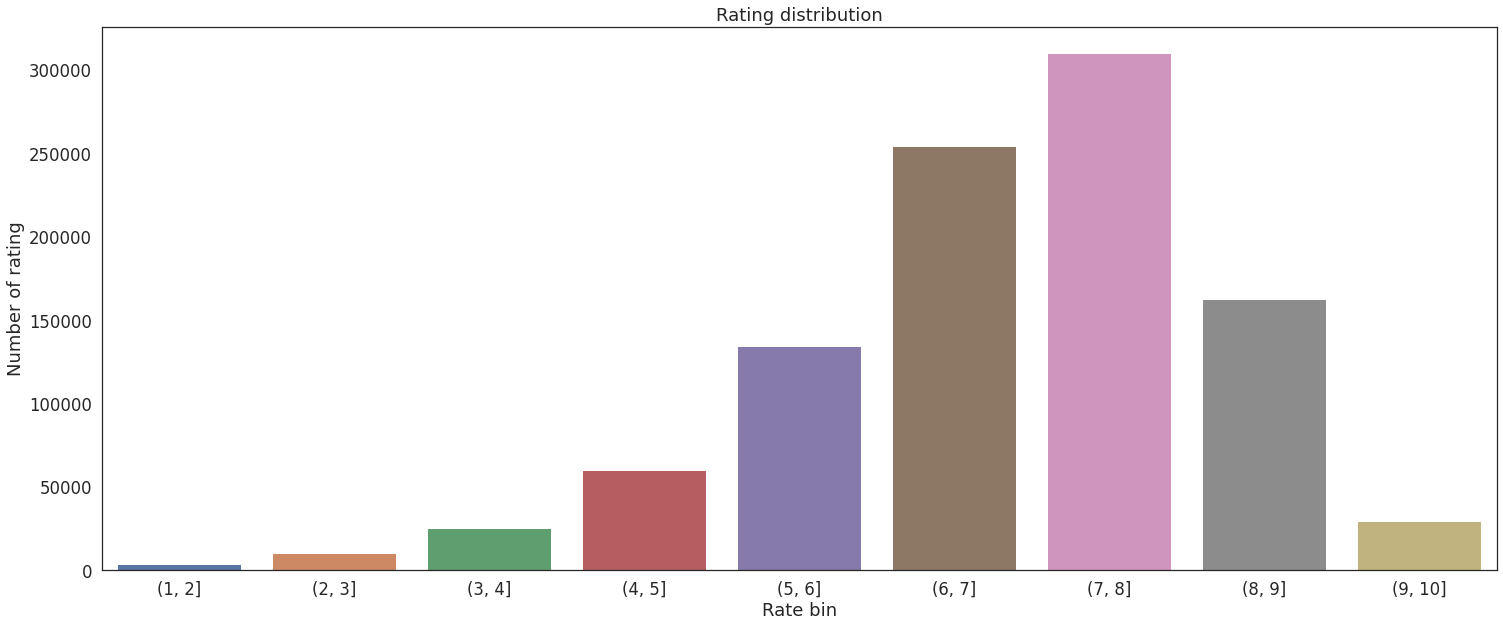

In [ ]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=1.5)
ax = sns.barplot(x = rating_bins.index, y = rating_bins.values)
ax.set(title = "Rating distribution", xlabel = "Rate bin",  ylabel = "Number of rating")


In [ ]:
bins2 = [1,4,7,10]
rating_bins2 = df_rating.averageRating.groupby(pd.cut(df_rating.averageRating, bins2)).count()

[Text(0, 0.5, 'Number of rating'),
 Text(0.5, 0, 'Rate bin'),
 Text(0.5, 1.0, 'Rating distribution')]

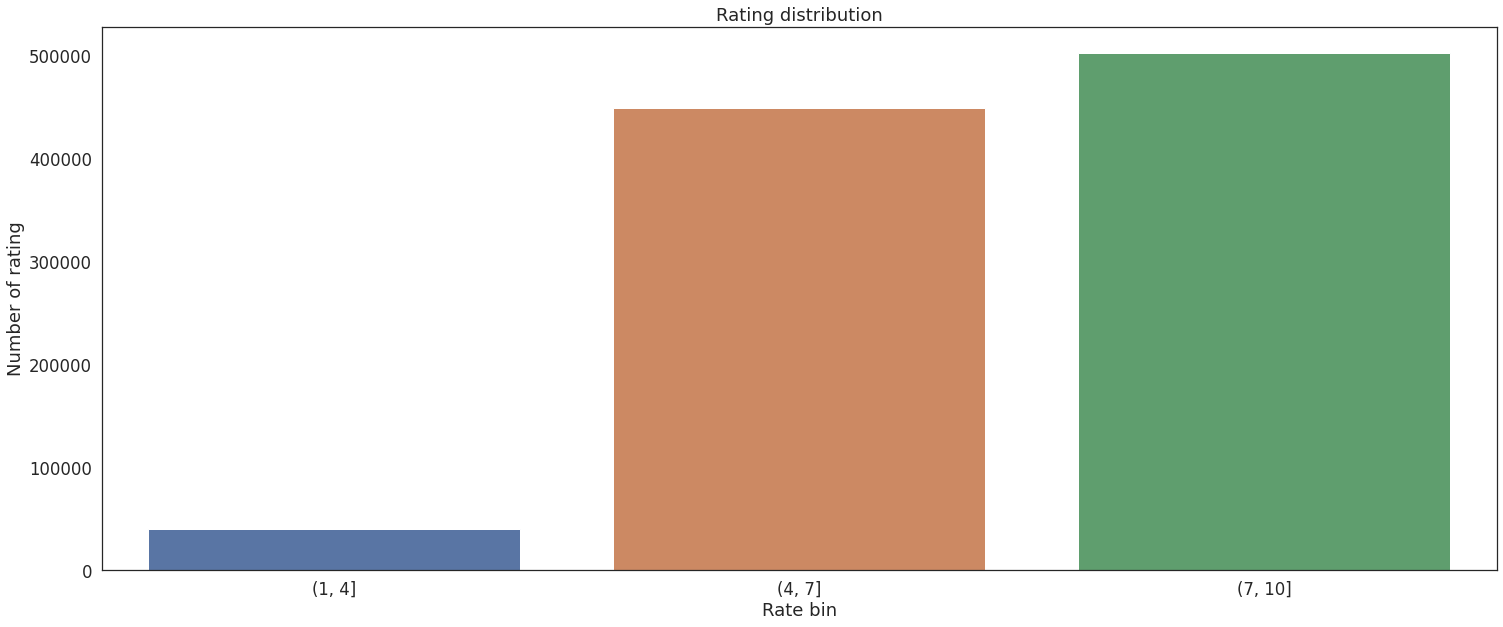

In [ ]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=1.5)
ax = sns.barplot(x = rating_bins2.index, y = rating_bins2.values)
ax.set(title = "Rating distribution", xlabel = "Rate bin",  ylabel = "Number of rating")


<hr>

<br>
<br>

### Movie genres

<br>





In [ ]:
genres = final_df.toPandas().genres

In [ ]:
from collections import defaultdict


genre_dict = defaultdict(int)

for s in genres:
  if s != "\\N":
    split = s.split(",")
    if len(split) > 1: 
      for string in split:
        genre_dict[string] += 1
    else:
      genre_dict[s]+= 1

In [ ]:
import pandas as pd 
genre_df = pd.DataFrame.from_dict(dict(genre_dict) ,orient='index')
genre_df.columns = ["num_movies"]

In [ ]:
genre_df.sort_values(by=['num_movies'],ascending=False, inplace=True)
#genre_df["genre"] = genre_df.index

In [ ]:
genre_df

,num_movies
Drama,451367
Comedy,261372
Romance,117911
Action,114311
Crime,86893
Thriller,82071
Horror,71739
Adventure,67256
Mystery,36525
Family,36404


In [ ]:
genre_df["perc"]= genre_df.num_movies/genre_df.num_movies.sum()*100

In [ ]:
genre_df

,num_movies,perc
Drama,451367,28.829037
Comedy,261372,16.693961
Romance,117911,7.531035
Action,114311,7.301101
Crime,86893,5.549899
Thriller,82071,5.241916
Horror,71739,4.582006
Adventure,67256,4.295674
Mystery,36525,2.332870
Family,36404,2.325142


[Text(0, 0.5, 'Number of films'),
 Text(0.5, 0, 'Genre'),
 Text(0.5, 1.0, 'Genre distribution')]

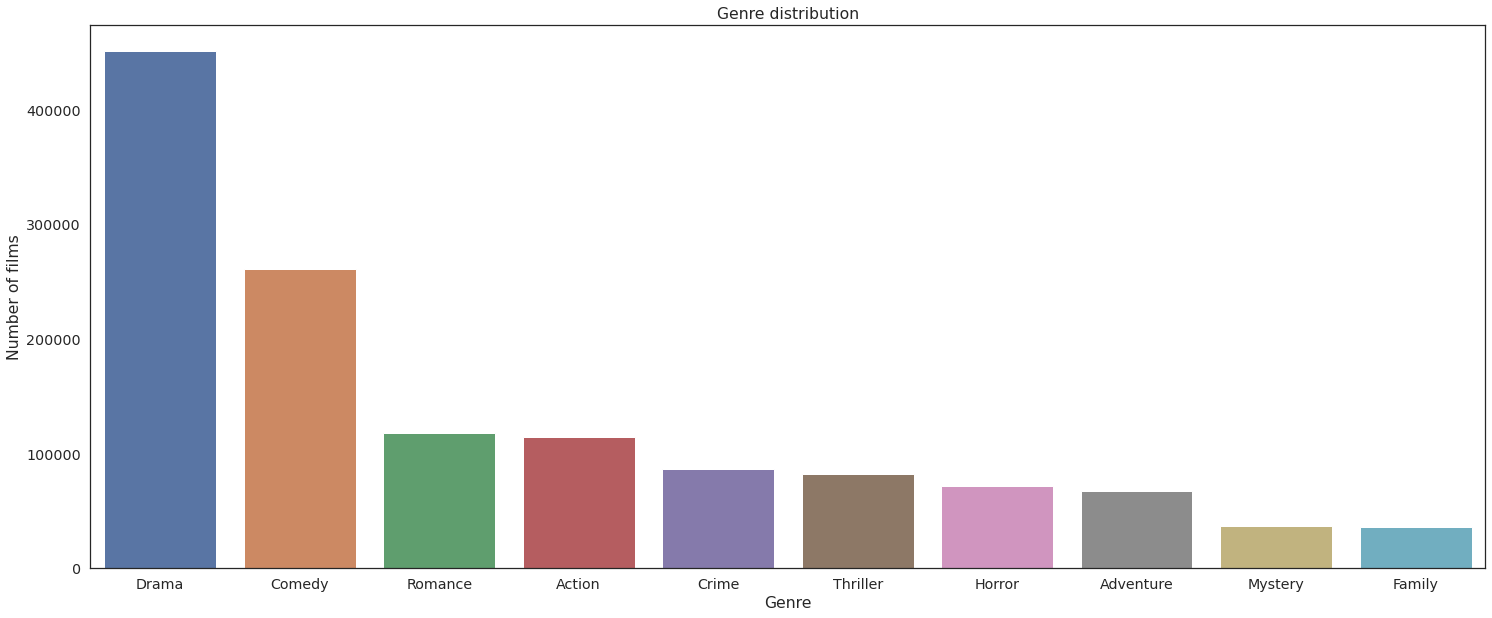

In [ ]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=1.3)
ax = sns.barplot(x = genre_df.index[0:10], y = "num_movies", data = genre_df.head(10))
ax.set(title = "Genre distribution", xlabel = "Genre",  ylabel = "Number of films")


In [ ]:
import operator
from collections import OrderedDict

perc_genre_dict = genre_df[["perc"]].to_dict()
sorted_tuples = sorted(perc_genre_dict.items(), key=operator.itemgetter(1),reverse= True)
print(sorted_tuples)  # [(1, 1), (3, 4), (2, 9)]

sorted_dict = OrderedDict()
for k, v in sorted_tuples:
    sorted_dict[k] = v

sorted_dict = sorted_dict['perc']

[('perc', {'Drama': 28.82903655181047, 'Comedy': 16.69396066088085, 'Romance': 7.531034676572555, 'Action': 7.301100871960084, 'Crime': 5.549899467830984, 'Thriller': 5.241915910652834, 'Horror': 4.582005891415038, 'Adventure': 4.295674434171229, 'Mystery': 2.3328700592973735, 'Family': 2.325141728642343, 'Fantasy': 1.8936326219862705, 'Sci-Fi': 1.5669350079327162, 'Documentary': 1.540237138397157, 'Musical': 1.4895239603798507, 'Adult': 1.4026600786373613, 'War': 1.3023195211245295, 'History': 1.2194794809627585, 'Western': 1.1142847653525525, 'Biography': 1.0875868958169932, 'Music': 1.026143473584438, 'Animation': 0.9385770163278551, 'Sport': 0.49640153595781483, 'Film-Noir': 0.20310819407435035, 'News': 0.030146876604746346, 'Reality-TV': 0.004215453084561989, 'Game-Show': 0.000766446015374907, 'Talk-Show': 0.0007025755140936649, 'Short': 0.0006387050128124226})]


In [ ]:
dic = sorted_dict

import itertools
newdic={}
for key, group in itertools.groupby(dic, lambda k: 'Others' if (dic[k]<1.1) else k):
     newdic[key] = sum([dic[k] for k in list(group)])   

labels = newdic.keys()
sizes = newdic.values()

perc_df = pd.DataFrame(sizes,labels, columns=["perc"])

In [ ]:
perc_df

,perc
Drama,28.829037
Comedy,16.693961
Romance,7.531035
Action,7.301101
Crime,5.549899
Thriller,5.241916
Horror,4.582006
Adventure,4.295674
Mystery,2.332870
Family,2.325142


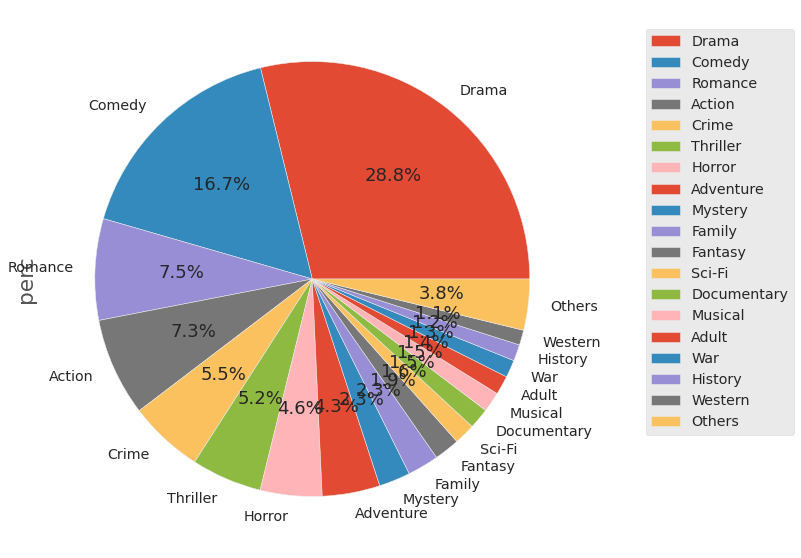

In [ ]:
perc_df.plot.pie(autopct="%.1f%%", y = "perc").legend(loc="lower left", bbox_to_anchor=(1.1, 0.2), ncol= 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  import sys


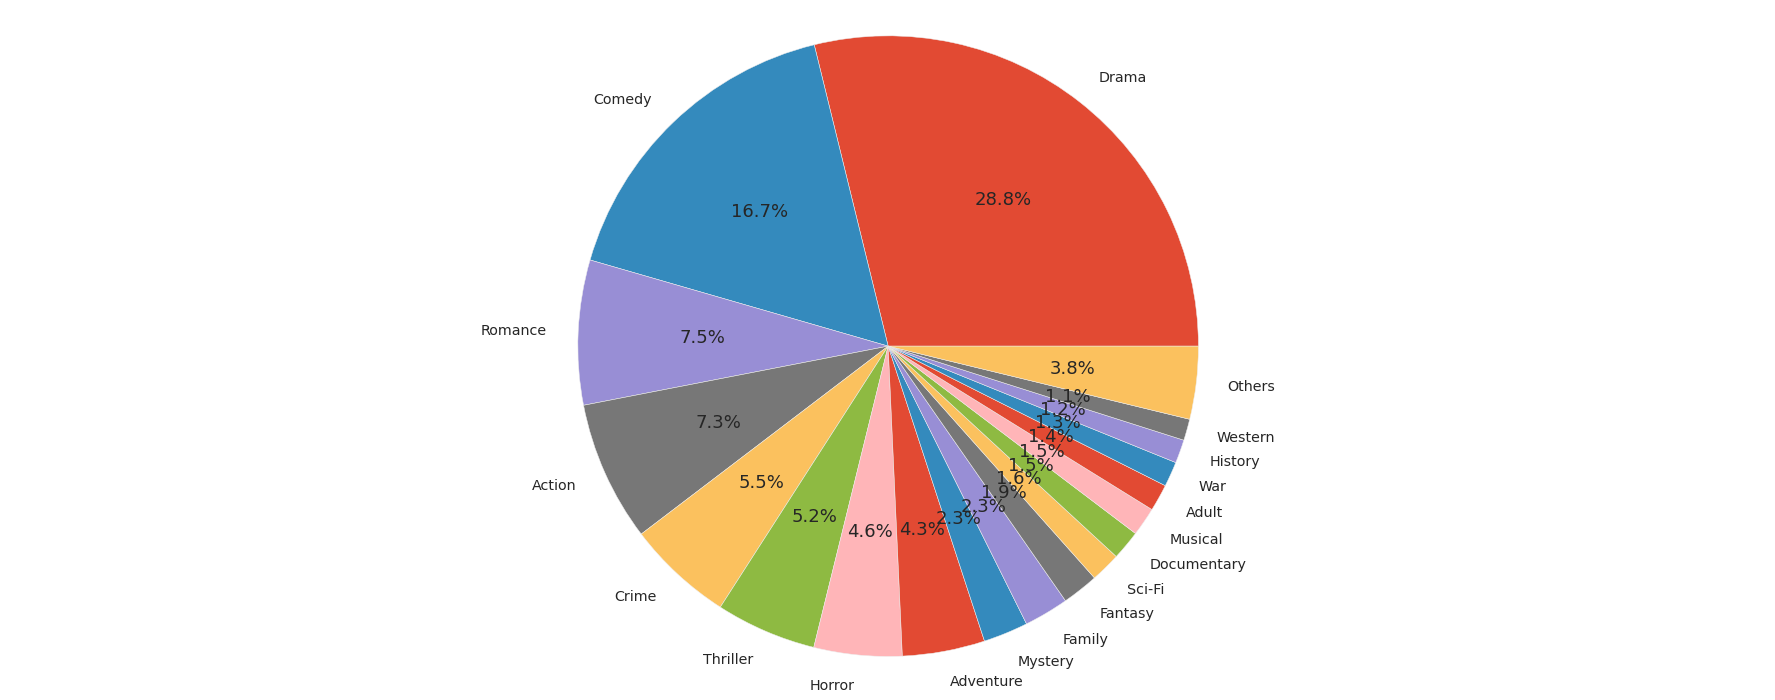

In [ ]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0)
ax.axis('equal',fontsize=24)
plt.tight_layout()

plt.show()



<hr>

<br>
<br>

### Movies with more actors

<br>

In [ ]:
query = """SELECT primaryTitle, count(primaryTitle) AS num_actors
           from mergedataset
           group by primaryTitle
           ORDER BY num_actors DESC
           LIMIT 10
           """
res1 = spark.sql(query)
ds = res1.toPandas()
res1.show()

+------------+----------+
|primaryTitle|num_actors|
+------------+----------+
|      Hamlet|       145|
|     Macbeth|       140|
|   Honeymoon|       139|
|      Broken|       131|
|       Alone|       128|
|        Love|       127|
|      Desire|       125|
|      Mother|       123|
|  Homecoming|       117|
|     Revenge|       115|
+------------+----------+



[Text(0, 0.5, 'Number of actors'),
 Text(0.5, 0, 'Movie title'),
 Text(0.5, 1.0, 'Movies with more actors')]

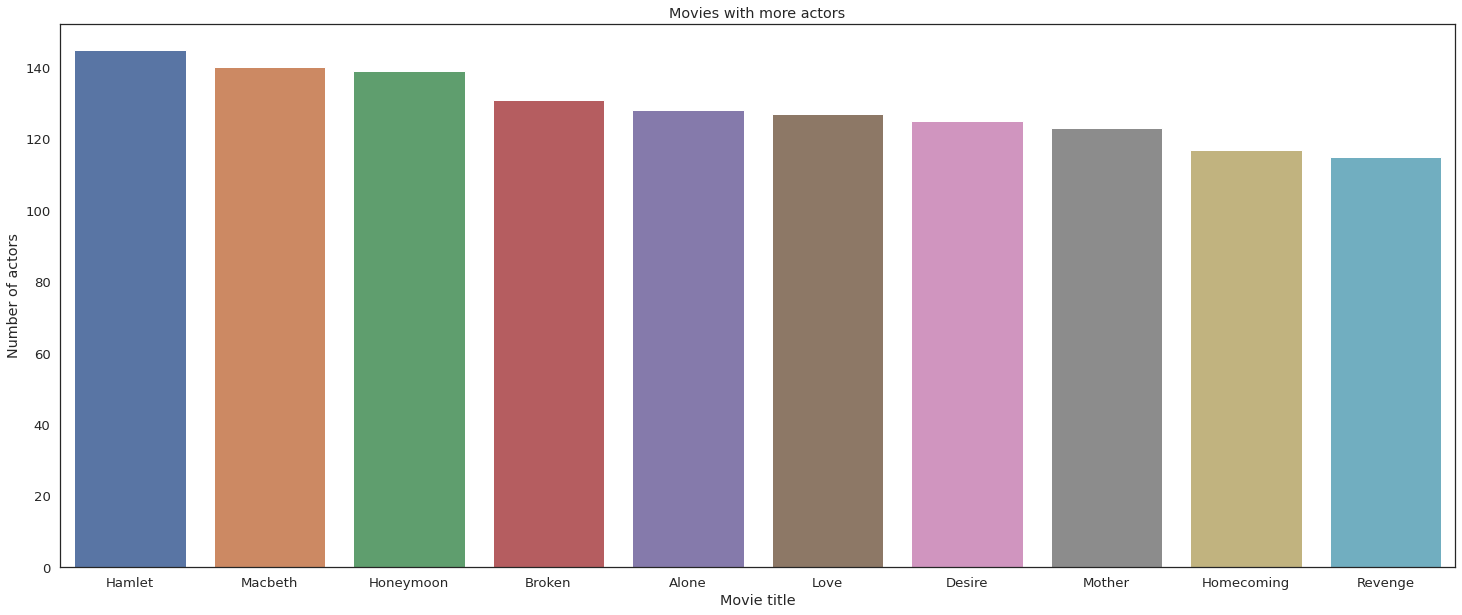

In [ ]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=1.2)
ax = sns.barplot(x = "primaryTitle", y = "num_actors", data = ds)
ax.set(title = "Movies with more actors", xlabel = "Movie title",  ylabel = "Number of actors")


In [ ]:
query = """SELECT primaryTitle, primaryName, nconst
           from mergedataset
           where primaryTitle = 'Hamlet'
           """
spark.sql(query).show()

+------------+--------------------+---------+
|primaryTitle|         primaryName|   nconst|
+------------+--------------------+---------+
|      Hamlet|      Lara Gilchrist|nm1968493|
|      Hamlet|      Gillian Barber|nm0053390|
|      Hamlet|        Bruce Ramsay|nm0708873|
|      Hamlet|     Peter Wingfield|nm0935057|
|      Hamlet|        Helen Mirren|nm0000545|
|      Hamlet|       Quentin Crisp|nm0187998|
|      Hamlet|       Barry Stanton|nm0822719|
|      Hamlet|      Vladek Sheybal|nm0792996|
|      Hamlet|        Tim Campbell|nm8002435|
|      Hamlet|      Adrienne Gould|nm0332306|
|      Hamlet|          Tom Rooney|nm6203587|
|      Hamlet|       Seana McKenna|nm0571426|
|      Hamlet|      Thomas Olajide|nm4731835|
|      Hamlet|       Jonathan Goad|nm1770824|
|      Hamlet|    Mikhail Nazvanov|nm0623442|
|      Hamlet|Innokentiy Smoktu...|nm0810550|
|      Hamlet|        Elza Radzina|nm0705952|
|      Hamlet|      Yuriy Tolubeev|nm0866264|
|      Hamlet|    Vasiko Bakhtadze

<hr>

<br>
<br>

## Actors
<br>


<hr>

<br>
<br>

### Actors play in more movies

<br>


In [ ]:
query = """select primaryName, count(primaryName) as num_movies
           from mergedataset
           group by primaryName
            ORDER BY num_movies DESC
            LIMIT 10
           """
res = spark.sql(query)
ds2 = res.toPandas()
res.show()

+----------------+----------+
|     primaryName|num_movies|
+----------------+----------+
|    Brahmanandam|       798|
|     Adoor Bhasi|       585|
|Matsunosuke Onoe|       565|
|    Eddie Garcia|       507|
|      Prem Nazir|       438|
|    Sung-il Shin|       411|
|    Paquito Diaz|       391|
|Masayoshi Nogami|       387|
|       Mammootty|       381|
|  Aachi Manorama|       355|
+----------------+----------+



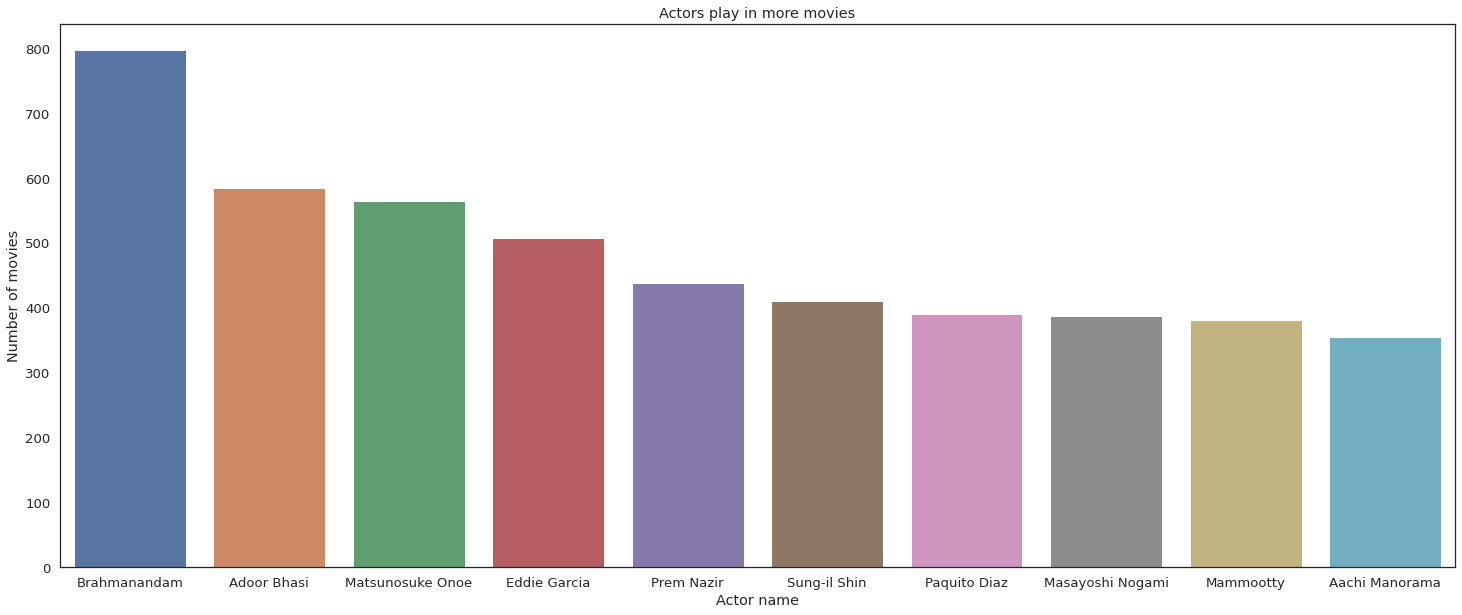

In [ ]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=1.2)
ax = sns.barplot(x = "primaryName", y = "num_movies", data = ds2)
ax.set(title = "Actors play in more movies", xlabel = "Actor name", ylabel = "Number of movies");

<hr>

<br>
<br>

### Age distribution

<br>


In [ ]:
query = """select min(birthYear), max(birthYear)
          from mergedataset
        """
res3 = spark.sql(query)
res3.show()



+--------------+--------------+
|min(birthYear)|max(birthYear)|
+--------------+--------------+
|          0004|            \N|
+--------------+--------------+



In [ ]:
query = """select min(birthYear), max(birthYear)
          from mergedataset
          where birthYear < 2022 and birthYear > 10
        """
res3 = spark.sql(query)
res3.show()


+--------------+--------------+
|min(birthYear)|max(birthYear)|
+--------------+--------------+
|          0021|          2012|
+--------------+--------------+



In [ ]:
query = """select birthYear, nconst, primaryName
          from mergedataset
          where birthYear < 1900
        """
res3 = spark.sql(query)
res3.show()

+---------+---------+-----------------+
|birthYear|   nconst|      primaryName|
+---------+---------+-----------------+
|     1877|nm0776747|     Harry Schumm|
|     1867|nm0383278|     Wilbur Higby|
|     1881|nm0285643|     Francis Ford|
|     1867|nm0445507|     Edgar Keller|
|     1877|nm0492302|       Burton Law|
|     1885|nm0092665|     Eddie Boland|
|     1876|nm0368875|    Jean Hathaway|
|     1893|nm0192062|     Grace Cunard|
|     1884|nm0793189|   Ernest Shields|
|     1888|nm0478359|Florence La Badie|
|     1877|nm0102718|    Sidney Bracey|
|     1873|nm0268437| Frank Farrington|
|     1889|nm0811293|  Marguerite Snow|
|     1884|nm0190516|      James Cruze|
|     1858|nm0394389|DeWolf Hopper Sr.|
|     1892|nm0269671|       Julia Faye|
|     1884|nm0863863|      Fay Tincher|
|     1875|nm0203439|     Max Davidson|
|     1889|nm0909648|     George Walsh|
|     1890|nm0593671|    Rhea Mitchell|
+---------+---------+-----------------+
only showing top 20 rows



In [ ]:
query = """select count(birthYear)
          from mergedataset
          where birthYear < 1900
        """
res3 = spark.sql(query)
res3.show()

+----------------+
|count(birthYear)|
+----------------+
|           47393|
+----------------+



In [ ]:
query = """select birthYear, nconst, primaryName
          from mergedataset
          where birthYear < 1800
        """
res3 = spark.sql(query)
res3.show()

+---------+---------+-----------+
|birthYear|   nconst|primaryName|
+---------+---------+-----------+
|     0004|nm0194670|Célina Cély|
|     0004|nm0194670|Célina Cély|
|     0021|nm8810146| Paul Walsh|
+---------+---------+-----------+



In [ ]:
query = """select min(birthYear), max(birthYear)
          from mergedataset
          where birthYear < 2022 and birthYear > 22
        """
res3 = spark.sql(query)
res3.show()


+--------------+--------------+
|min(birthYear)|max(birthYear)|
+--------------+--------------+
|          1830|          2012|
+--------------+--------------+



In [ ]:
query = """select min(deathYear), max(deathYear)
          from mergedataset
        """
res3 = spark.sql(query)
res3.show()



+--------------+--------------+
|min(deathYear)|max(deathYear)|
+--------------+--------------+
|          1908|            \N|
+--------------+--------------+



In [ ]:
query = """select min(deathYear), max(deathYear)
          from mergedataset
          where deathYear < 2022
        """
res3 = spark.sql(query)
res3.show()


+--------------+--------------+
|min(deathYear)|max(deathYear)|
+--------------+--------------+
|          1908|          2019|
+--------------+--------------+



In [ ]:
query = """select deathYear, nconst, primaryName
          from mergedataset
          where deathYear < 1900
        """
res3 = spark.sql(query)
res3.show()

+---------+------+-----------+
|deathYear|nconst|primaryName|
+---------+------+-----------+
+---------+------+-----------+



In [ ]:
query = """SELECT 
        count(CASE WHEN birthYear>= 1800 AND birthYear < 1850 THEN 1 END) AS 1800_1850,
        count(CASE WHEN birthYear>= 1850 AND birthYear < 1900 THEN 1 END) AS 1850_1900,
        count(CASE WHEN birthYear>= 1900 AND birthYear < 1925 THEN 1 END) AS 1900_1925,
        count(CASE WHEN birthYear>= 1925 AND birthYear < 1950 THEN 1 END) AS 1925_1950,
        count(CASE WHEN birthYear>= 1950 AND birthYear < 1975 THEN 1 END) AS 1950_1975,
        count(CASE WHEN birthYear>= 1975 AND birthYear < 2000 THEN 1 END) AS 1975_2000,
        count(CASE WHEN birthYear>= 2000 AND birthYear < 2022 THEN 1 END) AS 2000_2022
        FROM mergedataset AS AgeGroups
        """
res4 = spark.sql(query)
birth_df = res4.toPandas()

In [ ]:
birth_df

,0
1800_1850,131
1850_1900,47259
1900_1925,103986
1925_1950,164542
1950_1975,174098
1975_2000,84627
2000_2022,852


In [ ]:
birth_df = birth_df.T
#

In [ ]:
birth_df

,0
1800_1850,131
1850_1900,47259
1900_1925,103986
1925_1950,164542
1950_1975,174098
1975_2000,84627
2000_2022,852


In [ ]:
birth_df.columns  = ["value"]
birth_df

,value
1800_1850,131
1850_1900,47259
1900_1925,103986
1925_1950,164542
1950_1975,174098
1975_2000,84627
2000_2022,852


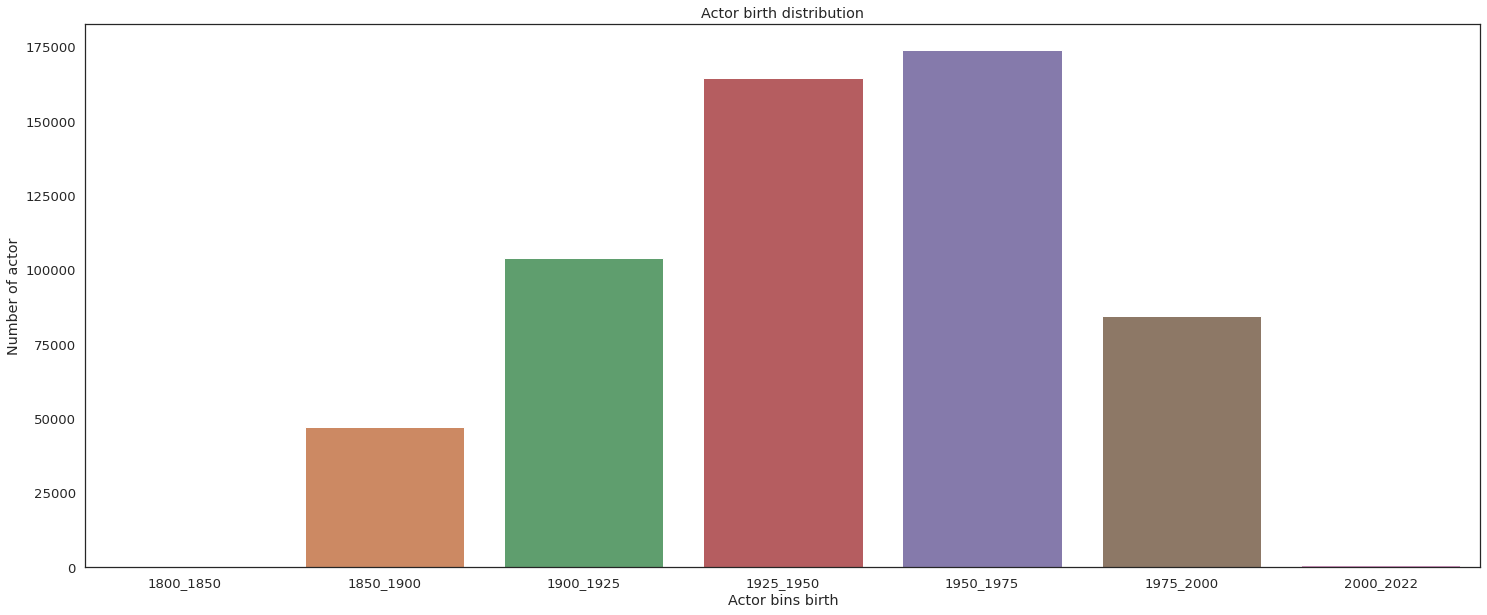

In [ ]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=1.2)
ax = sns.barplot(data = birth_df, x = birth_df.index, y = "value")
ax.set(title = "Actor birth distribution", xlabel = "Actor bins birth", ylabel = "Number of actor");

In [ ]:
query = """SELECT 
count(CASE WHEN deathYear>= 1900 AND deathYear < 1925 THEN 1 END) AS 1900_1925, 
count(CASE WHEN deathYear>= 1925 AND deathYear < 1950 THEN 1 END) AS 1925_1950,
count(CASE WHEN deathYear>= 1950 AND deathYear < 1975 THEN 1 END) AS 1950_1975,
count(CASE WHEN deathYear>= 1975 AND deathYear < 2000 THEN 1 END) AS 1975_2000,
count(CASE WHEN deathYear>= 2000 AND deathYear < 2022 THEN 1 END) AS 2000_2022
        FROM mergedataset AS AgeGroups
        """
res5 = spark.sql(query)

In [ ]:
death_df = res5.toPandas()

In [ ]:
death_df = death_df.T
death_df.columns= ["value"]
death_df

,value
1900_1925,731
1925_1950,14054
1950_1975,45125
1975_2000,86092
2000_2022,93302


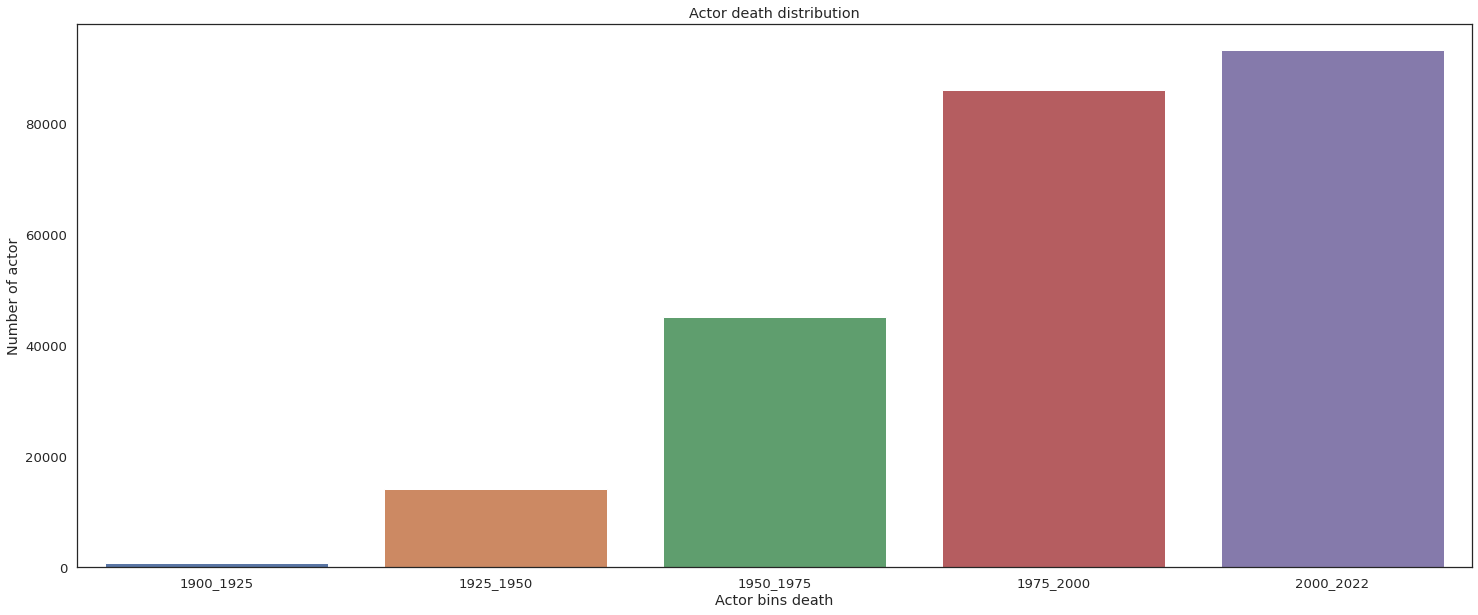

In [ ]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=1.2)
ax = sns.barplot(data = death_df, x = death_df.index, y = "value")
ax.set(title = "Actor death distribution", xlabel = "Actor bins death", ylabel = "Number of actor");

<hr>

<br>
<br>

# **Market Basket Analysis**
<br>


<hr>

<br>
<br>

### Basket building

<br>

In [ ]:
final_df.select("tconst","primaryName").show(20)

+---------+--------------------+
|   tconst|         primaryName|
+---------+--------------------+
|tt0000630|Fernanda Negri Po...|
|tt0000862|         Kate Fabian|
|tt0000862|      Schiøler Linck|
|tt0000862|Carl Johan Lundkvist|
|tt0000862|          O. Poulsen|
|tt0000862|       Hr. Andreasen|
|tt0000862|          Carl Hintz|
|tt0000941|    Joaquín Carrasco|
|tt0000941|         José Durany|
|tt0000941|     José Argelagués|
|tt0000941|      Elvira Fremont|
|tt0000992|       Edith Buemann|
|tt0001112|      Maria Caserini|
|tt0001112|      Dante Cappelli|
|tt0001482|       Wilfred Lucas|
|tt0001482|         Edna Foster|
|tt0001482|     Claire McDowell|
|tt0001531|        Lily Dampier|
|tt0001531|    Augustus Neville|
|tt0001531|        Alfred Rolfe|
+---------+--------------------+
only showing top 20 rows



In [ ]:
df = final_df.select("tconst","primaryName")

In [ ]:
df.show(10)

+---------+-----------------+
|   tconst|      primaryName|
+---------+-----------------+
|tt0004272|     Harry Schumm|
|tt0004272|     Wilbur Higby|
|tt0004272|     Francis Ford|
|tt0004272|     Edgar Keller|
|tt0004272|       Burton Law|
|tt0004272|     Eddie Boland|
|tt0004272|    Jean Hathaway|
|tt0004272|     Grace Cunard|
|tt0004272|   Ernest Shields|
|tt0004336|Florence La Badie|
+---------+-----------------+
only showing top 10 rows



In [ ]:
unique_names = df.select('primaryName').distinct()

In [ ]:
from pyspark.sql.functions import collect_set


In [ ]:
baskets = df.groupBy('tconst').agg(collect_set('primaryName').alias('items'))

In [ ]:
baskets.count()

214176

In [ ]:
baskets.show(20)

+---------+--------------------+
|   tconst|               items|
+---------+--------------------+
|tt0004272|[Wilbur Higby, Fr...|
|tt0004336|[Marguerite Snow,...|
|tt0005209|[DeWolf Hopper Sr...|
|tt0006204|[George Periolat,...|
|tt0006489|[Dorothy Dalton, ...|
|tt0006819|[Max Ruhbeck, Eri...|
|tt0010060|[Bert Woodruff, R...|
|tt0011011|[Ica von Lenkeffy...|
|tt0011031|[Paul Biensfeldt,...|
|tt0013224|[Roy Atwell, Jame...|
|tt0014617|[Emil Rameau, Han...|
|tt0016361|[Malcolm McGregor...|
|tt0016395|[Ronald Colman, J...|
|tt0016679|[Shannon Day, Pat...|
|tt0016814|[Elga Brink, Walt...|
|tt0017866|[Reginald Denny, ...|
|tt0018526|[Fred Kohler, Cli...|
|tt0018537|[Kate Fabian, Pet...|
|tt0019388|[Josephine Dunn, ...|
|tt0019473|[Margaret Livings...|
+---------+--------------------+
only showing top 20 rows



<hr>

<br>
<br>

### FPGrowth Algoritm

<br>

In [ ]:
from pyspark.ml.fpm import FPGrowth




In [ ]:
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.00005, minConfidence=0)
model = fpGrowth.fit(baskets)

In [35]:
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")
mostPopularItemInABasket.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+----+
|               items|freq|
+--------------------+----+
|       [Ashok Kumar]| 198|
|      [Brahmanandam]| 412|
|        [Dharmendra]| 237|
|        [Ron Jeremy]| 228|
|          [Mohanlal]| 321|
|         [Tom Byron]| 227|
|         [Mammootty]| 312|
| [Jagathi Sreekumar]| 218|
|[Mithun Chakraborty]| 298|
|      [Cüneyt Arkin]| 281|
|        [Mohan Babu]| 217|
|          [Rajkumar]| 212|
|           [Sridevi]| 242|
+--------------------+----+



In [36]:
query = """select items, freq
           from mostPopularItemInABasket
           order by freq desc
           limit 20"""
spark.sql(query).show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|      [Brahmanandam]| 412|
|          [Mohanlal]| 321|
|         [Mammootty]| 312|
|[Mithun Chakraborty]| 298|
|      [Cüneyt Arkin]| 281|
|           [Sridevi]| 242|
|        [Dharmendra]| 237|
|        [Ron Jeremy]| 228|
|         [Tom Byron]| 227|
| [Jagathi Sreekumar]| 218|
|        [Mohan Babu]| 217|
|          [Rajkumar]| 212|
|       [Ashok Kumar]| 198|
+--------------------+----+



In [ ]:
query = """select items, freq
           from mostPopularItemInABasket
           where size(items) > 2
           order by freq desc
           limit 20"""
spark.sql(query).show()



+--------------------+----+
|               items|freq|
+--------------------+----+
|[Eddy Waller, Bla...|  30|
|[Larry Simms, Pen...|  28|
|[Dale Evans, Trig...|  28|
|[Gabriel Dell, Le...|  25|
|[M.G. Ramachandra...|  24|
|[Nobuyo Ôyama, Ka...|  23|
|[Michiko Nomura, ...|  22|
|[Nobuyo Ôyama, Mi...|  22|
|[Black Jack, Alla...|  21|
|[Nobuyo Ôyama, Mi...|  21|
|[Nobuyo Ôyama, Mi...|  21|
|[David Gerrold, D...|  21|
|[Eddy Waller, All...|  19|
|[Elmer, John 'Dus...|  19|
|[Marieve Heringto...|  19|
|[Jason Barker, Do...|  19|
|[Gin Maeda, Kiyos...|  19|
|[Eddy Waller, Bla...|  18|
|[Marieve Heringto...|  18|
|[Ashwath, Balkris...|  18|
+--------------------+----+



In [ ]:
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.show()

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|       [Jerry Lewis]|       [Dean Martin]|0.30434782608695654|1330.2857142857144|6.536680113551472E-5|
|[Kyle Rea, Robert...|   [G. Larry Butler]|                1.0| 6490.181818181818|5.135962946361871E-5|
|[Dimitris Papamic...|[Aliki Vougiouklaki]| 0.3902439024390244|1899.5654101995565|7.470491558344539E-5|
|      [Sudhir Joshi]|   [Laxmikant Berde]| 0.5217391304347826|1470.3157894736842|5.602868668758404...|
|         [Tom Tyler]|        [Bob Steele]|0.18421052631578946|334.35147190008917|6.536680113551472E-5|
|         [Ric Lutze]|         [Rene Bond]| 0.4492753623188406| 1688.140350877193|1.447407739429254...|
|[Nandamuri Balakr...|       [Vijayshanti]|0.17333333333333334| 

In [ ]:
associationRules.count()

2530

In [ ]:
assoc_rules = associationRules.toPandas()

In [ ]:
assoc_rules.confidence.describe()

count    2530.000000
mean        0.418687
std         0.337238
min         0.026699
25%         0.128793
50%         0.281651
75%         0.750000
max         1.000000
Name: confidence, dtype: float64

In [ ]:
assoc_rules.support.describe()

count    2530.000000
mean        0.000074
std         0.000030
min         0.000051
25%         0.000056
50%         0.000065
75%         0.000079
max         0.000346
Name: support, dtype: float64

In [ ]:
query = """select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence
           from associationRules
           order by confidence desc
           limit 20"""

res = spark.sql(query)
res.show()



+--------------------+-------------------+----------+
|     antecedent (if)|  consequent (then)|confidence|
+--------------------+-------------------+----------+
|[David Gerrold, D...|  [G. Larry Butler]|       1.0|
|[Bradford Hill, R...|[Marieve Herington]|       1.0|
|[Marieve Heringto...|  [G. Larry Butler]|       1.0|
|     [Lesley Easter]| [Paul T.T. Easter]|       1.0|
|[Bradford Hill, R...|  [G. Larry Butler]|       1.0|
|[Bradford Hill, D...|   [Donald F. Glut]|       1.0|
|[Mona Geijer-Falk...|    [John Elfström]|       1.0|
|[Marieve Heringto...|    [David Gerrold]|       1.0|
|[Jason Barker, Ro...|    [David Gerrold]|       1.0|
|[Marieve Heringto...|    [Bradford Hill]|       1.0|
|[Kyle Rea, Robert...|    [David Gerrold]|       1.0|
|[S.A. Ashokan, M....|[M.G. Ramachandran]|       1.0|
|[Bradford Hill, J...|  [G. Larry Butler]|       1.0|
|[Marieve Heringto...|  [G. Larry Butler]|       1.0|
|[Bradford Hill, M...|  [G. Larry Butler]|       1.0|
|        [Larry Fine]|      

In [ ]:
associations = model.transform(baskets)
associations.show(n=200)

+---------+--------------------+--------------------+
|   tconst|               items|          prediction|
+---------+--------------------+--------------------+
|tt0004272|[Wilbur Higby, Fr...|                  []|
|tt0004336|[Marguerite Snow,...|                  []|
|tt0005209|[DeWolf Hopper Sr...|                  []|
|tt0006204|[George Periolat,...|                  []|
|tt0006489|[Dorothy Dalton, ...|                  []|
|tt0006819|[Max Ruhbeck, Eri...|                  []|
|tt0010060|[Bert Woodruff, R...|                  []|
|tt0011011|[Ica von Lenkeffy...|                  []|
|tt0011031|[Paul Biensfeldt,...|                  []|
|tt0013224|[Roy Atwell, Jame...|                  []|
|tt0014617|[Emil Rameau, Han...|                  []|
|tt0016361|[Malcolm McGregor...|                  []|
|tt0016395|[Ronald Colman, J...|                  []|
|tt0016679|[Shannon Day, Pat...|                  []|
|tt0016814|[Elga Brink, Walt...|                  []|
|tt0017866|[Reginald Denny, 

In [ ]:
import networkx as nx
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import matplotlib.pyplot as plt

def generate_graph_draw(baskets, minSupp, minConf):

  fpGrowth = FPGrowth(itemsCol="items", minSupport=minSupp, minConfidence=minConf)
  model= fpGrowth.fit(baskets)

  ar = model.associationRules.toPandas()
  node_dict = dict()
  G = nx.Graph()
  names = []
  for i in range(len(ar["antecedent"])):
    item = str(ar["antecedent"][i])
    item2 =  str(ar["consequent"][i])
    names.append(item)
    node_dict[item] = item2
  # print(item," --- ", item2)
    G.add_node(item)
    G.add_edge(item,item2)

  print('Number of nodes: {} - Number of links:{}'.format(G.order(),G.size()))

  names = list(dict.fromkeys(names))
  if G.size() != 0:
  # draw the graph
    if G.size() < 100:
     k_par = 1
    else:
      k_par = 0.3
    
    pos = nx.spring_layout(G, k = k_par, iterations=50)

    plt.figure(figsize=(20,20)) 
    nx.draw_networkx_nodes(G, pos, node_size=100, label = names)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G,pos,font_size=7,font_color='black')
    plt.show()
  else:
    print("No graph to draw (size is 0)")
  
  return model

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
model = generate_graph_draw(baskets,0.001,0) 

Number of nodes: 0 - Number of links:0
No graph to draw (size is 0)


FPGrowthModel: uid=FPGrowth_c24ef3cba5ae, numTrainingRecords=214176

Number of nodes: 4 - Number of links:2


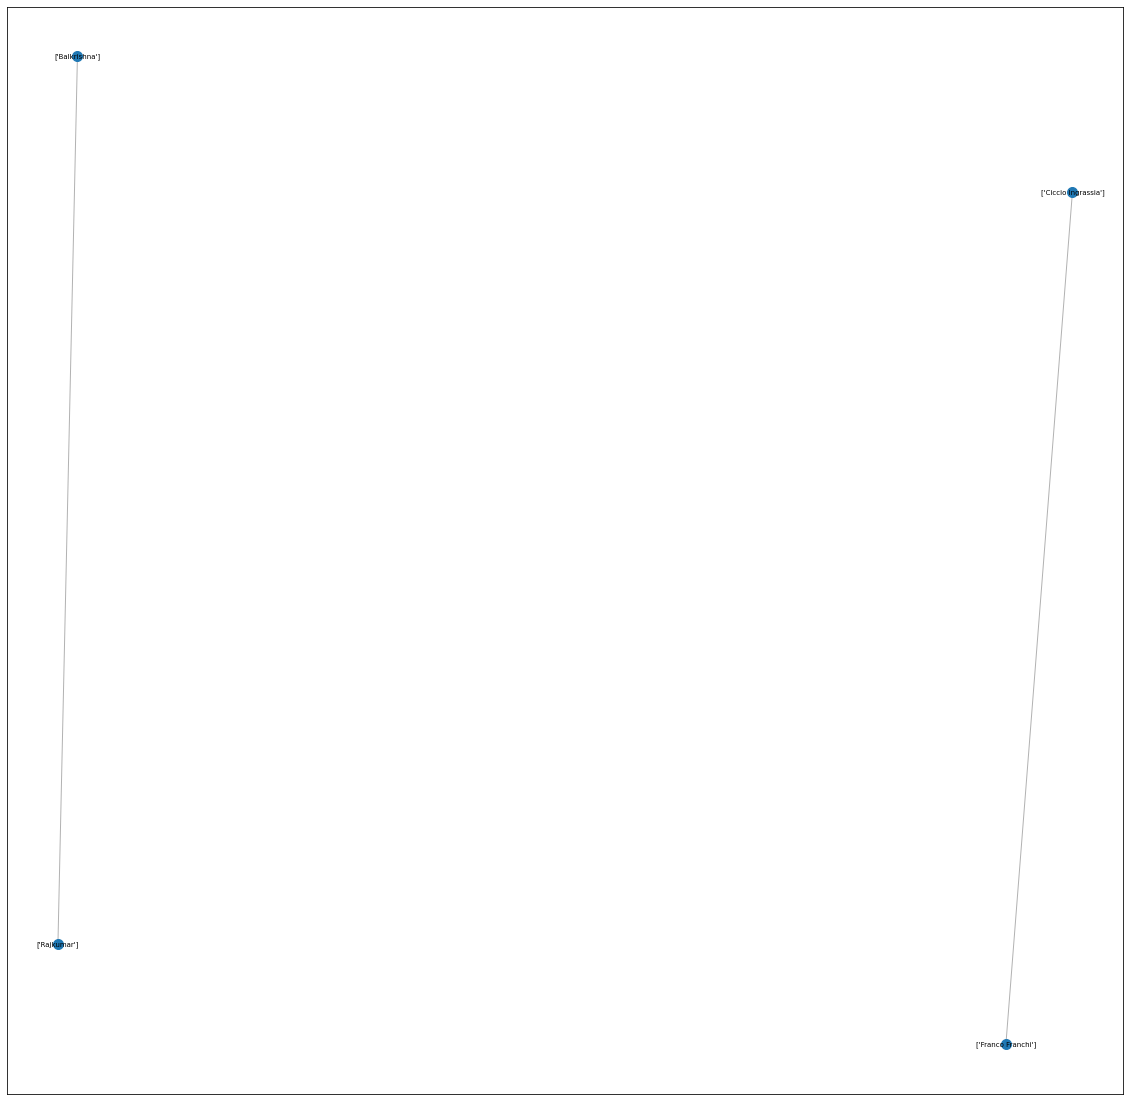

FPGrowthModel: uid=FPGrowth_e8f3fa91da7b, numTrainingRecords=214176

In [ ]:
model2 = generate_graph_draw(baskets,0.0003,0) 

Number of nodes: 22 - Number of links:11


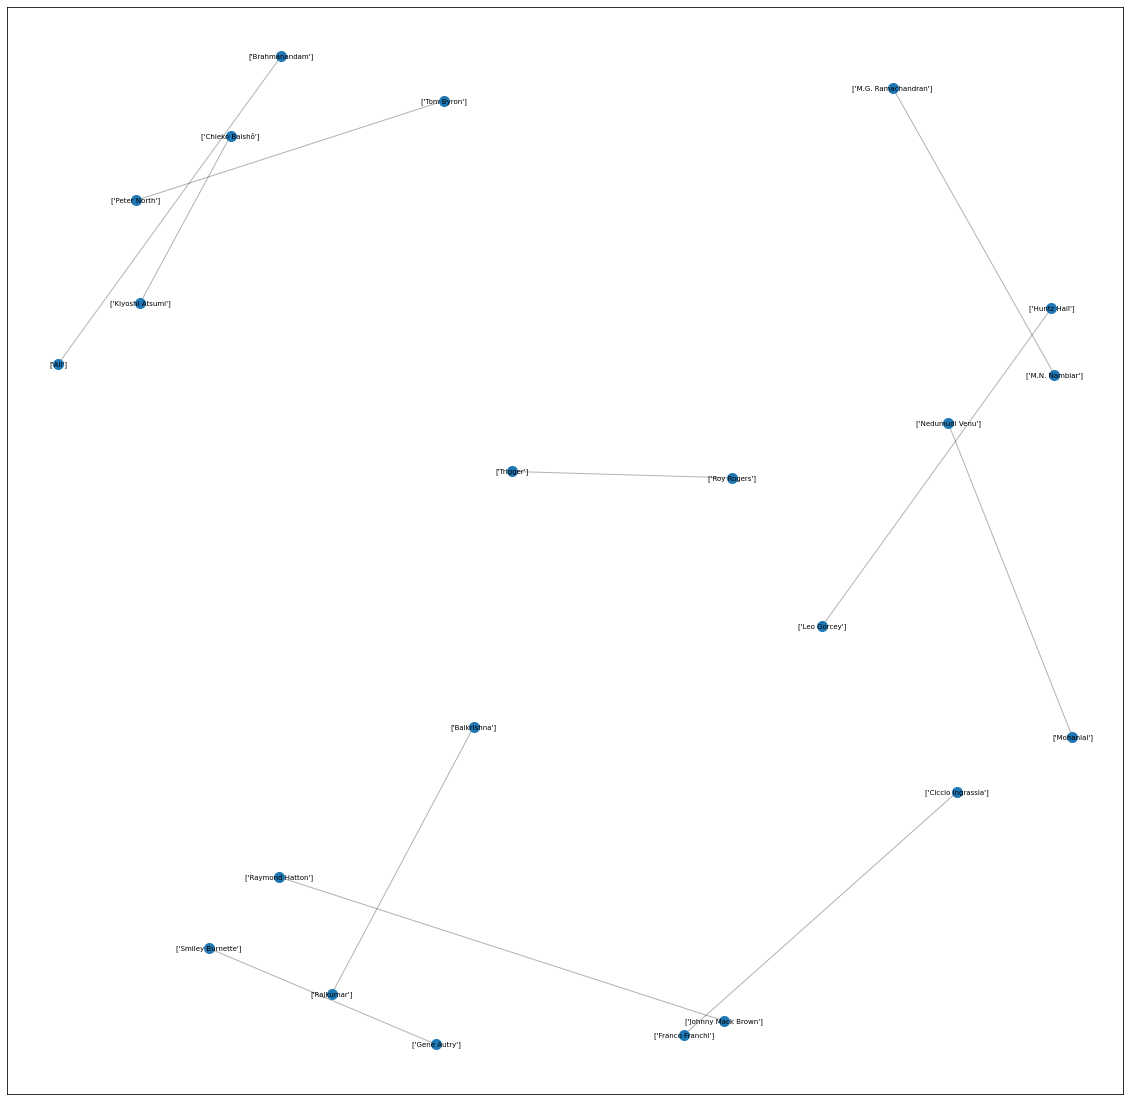

FPGrowthModel: uid=FPGrowth_af6a1d3be7d1, numTrainingRecords=214176

In [ ]:
model3 = generate_graph_draw(baskets,0.0002, 0)

Number of nodes: 174 - Number of links:156


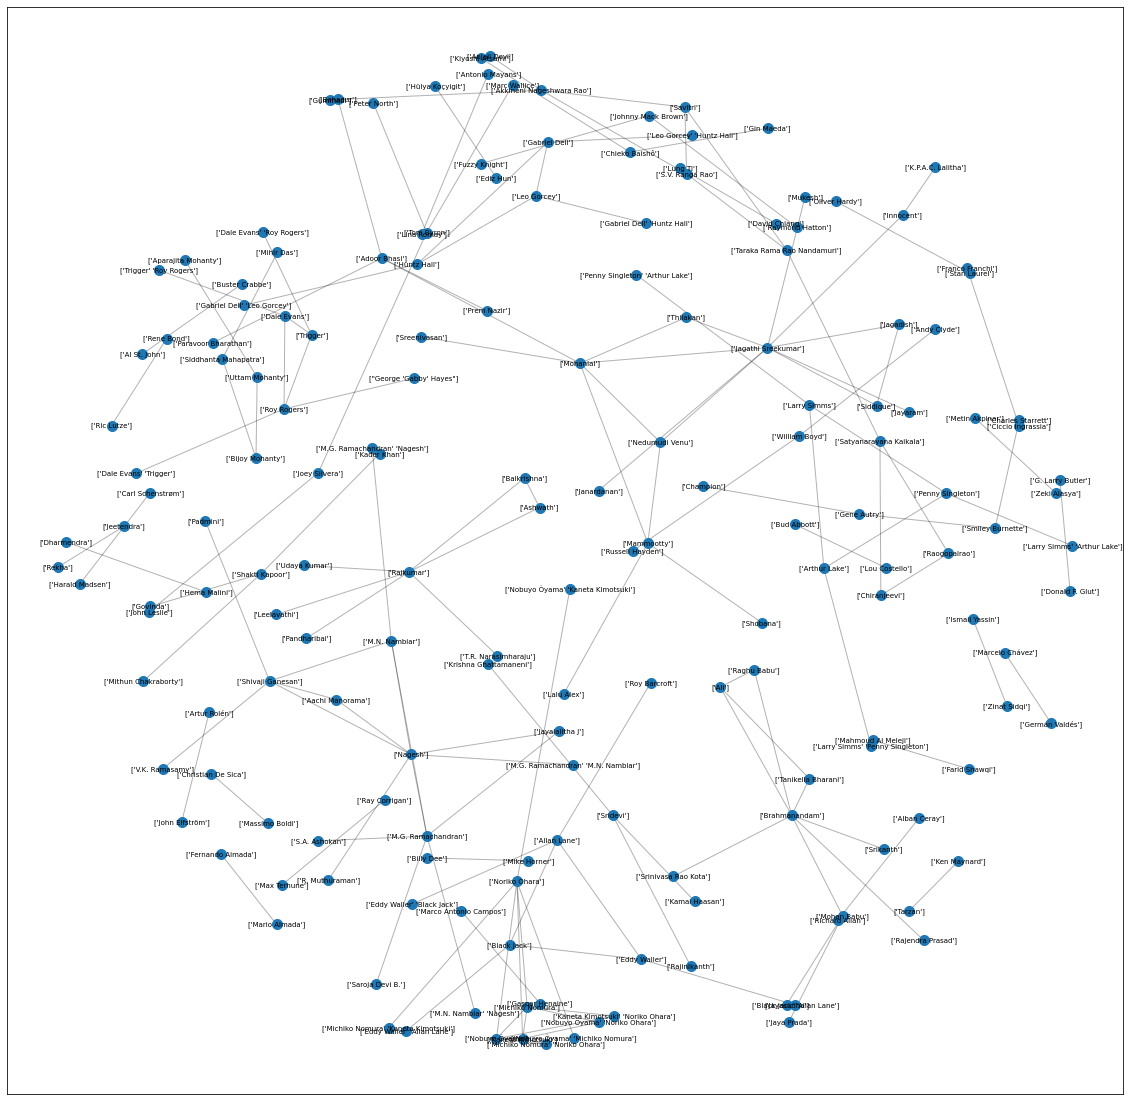

FPGrowthModel: uid=FPGrowth_7f6b392c2b9e, numTrainingRecords=214176

In [ ]:
model4 = generate_graph_draw(baskets,0.0001,0) 

Number of nodes: 1061 - Number of links:1583


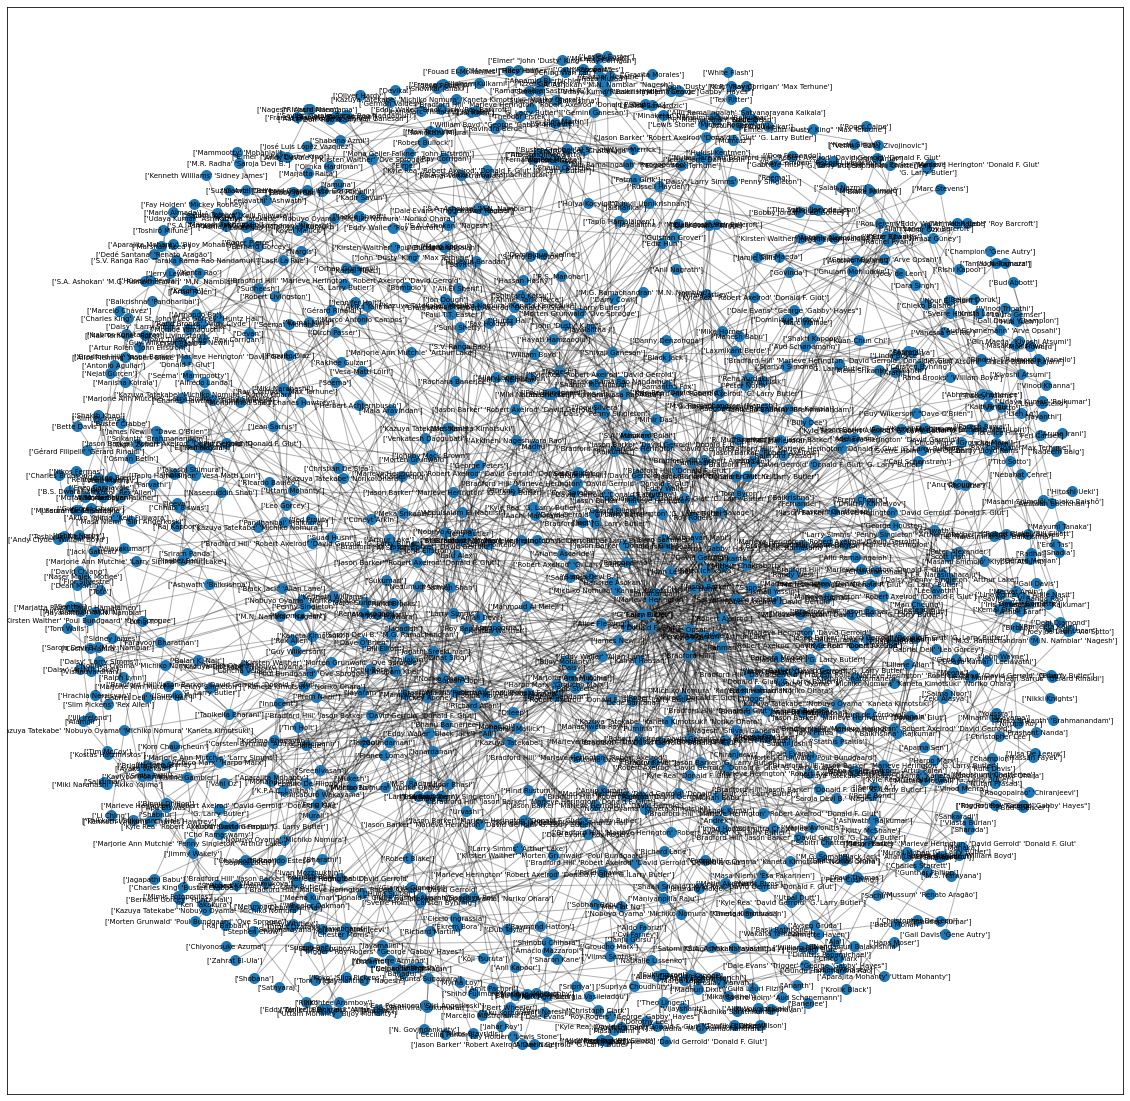

FPGrowthModel: uid=FPGrowth_a3e165f878bf, numTrainingRecords=214176

In [ ]:
model5 = generate_graph_draw(baskets,0.00005,0) 

In [31]:
import numpy as np


sizes= dict()
for supp in list(np.arange(0.000001,0.00001,0.000001))+list(np.arange(0.00001,0.0001,0.00001))+list(np.arange(0.0001,0.001,0.0001)):
  print("SUPP:", supp)
  fpGrowth = FPGrowth(itemsCol="items", minSupport=supp, minConfidence=0)
  model= fpGrowth.fit(baskets)
  n= model.associationRules.count() 
  sizes[supp] = n
  print('CNT:'+str(n)+"\n---\n")

SUPP: 1e-06


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


CNT:24902854
---

SUPP: 2e-06
CNT:24902854
---

SUPP: 3e-06
CNT:24902854
---

SUPP: 4e-06
CNT:24902854
---

SUPP: 4.9999999999999996e-06
CNT:363905
---

SUPP: 5.999999999999999e-06
CNT:363905
---

SUPP: 7e-06
CNT:363905
---

SUPP: 8e-06
CNT:363905
---

SUPP: 9e-06
CNT:363905
---

SUPP: 1e-05
CNT:83128
---

SUPP: 2e-05
CNT:18840
---

SUPP: 3.0000000000000004e-05
CNT:7626
---

SUPP: 4e-05
CNT:4094
---

SUPP: 5e-05
CNT:2530
---

SUPP: 6e-05
CNT:1636
---

SUPP: 7.000000000000001e-05
CNT:1092
---

SUPP: 8e-05
CNT:607
---

SUPP: 9e-05
CNT:409
---

SUPP: 0.0001
CNT:288
---

SUPP: 0.0002
CNT:22
---

SUPP: 0.00030000000000000003
CNT:4
---

SUPP: 0.0004
CNT:0
---

SUPP: 0.0005
CNT:0
---

SUPP: 0.0006000000000000001
CNT:0
---

SUPP: 0.0007000000000000001
CNT:0
---

SUPP: 0.0008
CNT:0
---

SUPP: 0.0009000000000000001
CNT:0
---



In [81]:
sizes

{1e-06: 24902854,
 2e-06: 24902854,
 3e-06: 24902854,
 4e-06: 24902854,
 4.9999999999999996e-06: 363905,
 5.999999999999999e-06: 363905,
 7e-06: 363905,
 8e-06: 363905,
 9e-06: 363905,
 1e-05: 83128,
 2e-05: 18840,
 3.0000000000000004e-05: 7626,
 4e-05: 4094,
 5e-05: 2530,
 6e-05: 1636,
 7.000000000000001e-05: 1092,
 8e-05: 607,
 9e-05: 409,
 0.0001: 288,
 0.0002: 22,
 0.00030000000000000003: 4,
 0.0004: 0,
 0.0005: 0,
 0.0006000000000000001: 0,
 0.0007000000000000001: 0,
 0.0008: 0,
 0.0009000000000000001: 0}

In [124]:
def cut_string(num):
  new_string = ""
  for i in num:
    if i != '0' and i!='.':
      new_string+=i
      break
    new_string+=i

  return new_string

In [125]:
new_sizes = []
for i in list(sizes.keys()):
  new_sizes.append(cut_string(format(i, 'f')))
#cut_string(format(list(sizes.keys())[17], 'f'))

In [126]:
new_sizes

['0.000001',
 '0.000002',
 '0.000003',
 '0.000004',
 '0.000005',
 '0.000006',
 '0.000007',
 '0.000008',
 '0.000009',
 '0.00001',
 '0.00002',
 '0.00003',
 '0.00004',
 '0.00005',
 '0.00006',
 '0.00007',
 '0.00008',
 '0.00009',
 '0.0001',
 '0.0002',
 '0.0003',
 '0.0004',
 '0.0005',
 '0.0006',
 '0.0007',
 '0.0008',
 '0.0009']

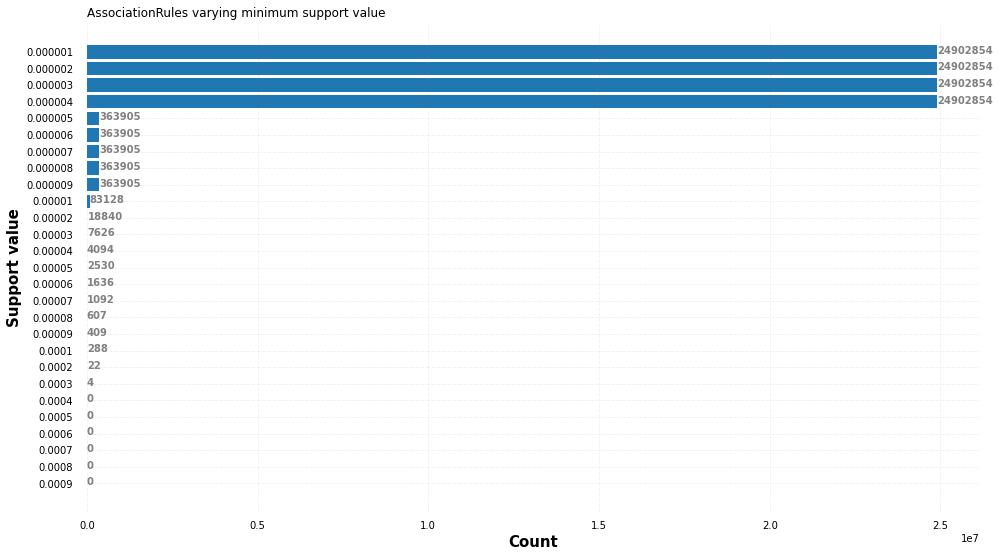

In [132]:
fig, ax = plt.subplots(figsize =(16, 9))

name =  new_sizes
count =sizes_df.num
# Horizontal Bar Plot
ax.barh(name, count)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize =  10, fontweight ='bold',
            color ='grey')
    
plt.xlabel('Count', fontweight ='bold', fontsize = 15)
plt.ylabel('Support value', fontweight ='bold', fontsize = 15)
# Add Plot Title
ax.set_title('AssociationRules varying minimum support value',
              loc ='left', )

# Show Plot
plt.show()